In [ ]:
pip install rdt


In [ ]:
from joblib import Parallel, delayed

class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalize them to a scalar between [-1, 1]
    and a vector. Discrete columns are encoded using a OneHotEncoder.
    """

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold,
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='continuous',
            transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components,
        )

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='discrete',
            transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories,
        )

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``ClusterBasedNormalizer`` for continuous columns and a
        ``OneHotEncoder`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns synchronous.

        Outputs a list with Numpy arrays.
        """
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns in parallel.

        Outputs a list with Numpy arrays.
        """
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        # Only use parallelization with larger data sizes.
        # Otherwise, the transformation will be slower.
        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data, self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(raw_data, self._column_transform_info_list)

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes())).astype(float)
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st : st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st
                )
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data
                )

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = pd.DataFrame(recovered_data, columns=column_names).astype(
            self._column_raw_dtypes
        )
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot),
        }


import pandas as pd
import torch
import torch.nn as nn
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
X = pd.read_csv("censusData.csv")
drive.mount('/content/drive')

categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country','income']
print("Categorical: ",categorical_columns)
continuous_columns = [col for col in X.columns if col not in categorical_columns]
print("Continuous: ",continuous_columns)

X['capital-gain-binary'] = (X['capital-gain'] != 0).astype(int)  # 1 if gain exists, 0 otherwise
categorical_columns.append('capital-gain-binary')
X['capital-loss-binary'] = (X['capital-loss'] != 0).astype(int)  # 1 if loss exists, 0 otherwise
categorical_columns.append('capital-loss-binary')

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary')
X_encoded_cat = encoder.fit_transform(X[categorical_columns])
categorical_columns_real = encoder.get_feature_names_out()
from collections import namedtuple

from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo',
    ['column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'],
)
import numpy as np
dataTrans = DataTransformer()
dataTrans.fit(X, categorical_columns)
train_data = dataTrans.transform(X)
X_continuous = X[continuous_columns].values
print(X[continuous_columns].values)
dataTrans.fit(pd.DataFrame(X[continuous_columns], columns = continuous_columns))
X_continuous = []
toSave = []
for i in range(len(continuous_columns)):
    column_transform_info = dataTrans._column_transform_info_list[i]
    column_name = column_transform_info.column_name
    #print(column_name)
    transformed_column = dataTrans._transform_continuous(column_transform_info, pd.DataFrame(X[column_name]))
   # print(transformed_column)
    cluster_assignments = np.argmax(transformed_column[:, 1:], axis=1)  # Extract original cluster assignments
    toSave.append((column_transform_info, cluster_assignments))
    X_continuous.append(np.expand_dims(transformed_column[:,0], axis=1))
X_continuous = np.concatenate(X_continuous, axis=1)
print(X_continuous)

print(torch.tensor(X_encoded_cat).shape)
X_encoded = torch.cat((torch.tensor(X_encoded_cat),torch.tensor(X_continuous)),dim=1)
dataset = list(X_encoded)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(X_encoded.shape)
columns = list(categorical_columns_real) + list(continuous_columns)
baseTruth = pd.DataFrame(X_encoded,columns = columns)
baseTruth.to_csv('base_truth.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Categorical:  ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
Continuous:  ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
[[  39   13 2174    0   40]
 [  50   13    0    0   13]
 [  38    9    0    0   40]
 ...
 [  38   13    0    0   50]
 [  44   13 5455    0   40]
 [  35   13    0    0   60]]
[[-4.81735581e-01  2.09453583e-03 -1.33843643e-01 -2.45830481e-04
  -5.64630074e-05]
 [-4.41787833e-02  2.09453583e-03 -3.10536227e-04 -2.45830481e-04
   4.18596044e-02]
 [-1.76794103e-01 -7.68821920e-04 -3.10536227e-04 -2.45830481e-04
  -5.64630074e-05]
 ...
 [ 2.60900999e-01  2.09453583e-03 -3.10536227e-04 -2.45830481e-04
  -3.67164036e-02]
 [-6.16925087e-01  2.09453583e-03  3.05262032e-01 -2.45830481e-04
  -5.64630074e-05]
 [-1.57565393e-02  2.09453583e-03 -3.10536227e-

AttributeError: 'DataFrame' object has no attribute 'save_csv'

In [ ]:
baseTruth.to_csv('base_truth.csv')

NameError: name 'categorical_columns' is not defined

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -1.5,
        grid_max: float = 1.5,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)


class BSRBF_KANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_size = 5,
        spline_order = 3,
        base_activation = torch.nn.SiLU,
        grid_range=[-1.5, 1.5],

    ) -> None:
        super().__init__()
        self.layernorm = nn.LayerNorm(input_dim)
        self.spline_order = spline_order
        self.grid_size = grid_size
        self.output_dim = output_dim
        self.base_activation = base_activation()
        self.input_dim = input_dim

        self.base_weight = torch.nn.Parameter(torch.Tensor(self.output_dim, self.input_dim))
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5))

        self.spline_weight = torch.nn.Parameter(torch.Tensor(self.output_dim, self.input_dim*(grid_size+spline_order)))
        torch.nn.init.kaiming_uniform_(self.spline_weight, a=math.sqrt(5))

        self.rbf = RadialBasisFunction(grid_range[0], grid_range[1], grid_size+spline_order)

        h = (grid_range[1] - grid_range[0]) / grid_size # 0.45, 0.5
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(self.input_dim, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)
        #self.linear = nn.Linear(self.input_dim*(grid_size+spline_order), self.output_dim)

        #self.drop = nn.Dropout(p=0.01) # dropout

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.input_dim

        grid: torch.Tensor = (
            self.grid
        )  # (input_dim, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            #print('-- k: ', k)
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.input_dim,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()


    def forward(self, x):

        # layer normalization
        device = x.device

        x = self.layernorm(x)
        #x = self.drop(x)

        # base
        #bias = torch.randn(self.output_dim)
        #base_output = F.linear(self.base_activation(x), self.base_weight, bias)
        base_output = F.linear(self.base_activation(x), self.base_weight)

        # b_splines
        bs_output = self.b_splines(x).view(x.size(0), -1)

        # rbf
        rbf_output = self.rbf(x).view(x.size(0), -1)
        #rbf_output = self.rbf(x)
        #rbf_output = torch.reshape(rbf_output, (rbf_output.shape[0], -1))

        # combine
        bsrbf_output = bs_output + rbf_output
        bsrbf_output = F.linear(bsrbf_output, self.spline_weight)

        return base_output + bsrbf_output

class BSRBF_KAN(torch.nn.Module):

    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        base_activation=torch.nn.SiLU,
    ):
        super(BSRBF_KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.layers = torch.nn.ModuleList()
        #self.drop = torch.nn.Dropout(p=0.1) # dropout

        for input_dim, output_dim in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                BSRBF_KANLayer(
                    input_dim,
                    output_dim,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    base_activation=base_activation,
                )
            )

    def forward(self, x: torch.Tensor):
        #x = self.drop(x)
        for layer in self.layers:
            x = layer(x)
        return x


In [ ]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
from torch.distributions import Bernoulli
import random
from google.colab import drive

attr = torch.load('census_attr_finalv2.pt').to(device)
index = torch.load('census_index_finalv2.pt').to(device).int()


class DeepLinear(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, xtra = False):
        super().__init__()

        self.layers = BSRBF_KAN([input_dim, hidden_dim//2,hidden_dim//2,output_dim], spline_order = 4,grid_size = 8).to(device)
        if xtra:
          self.layers = BSRBF_KAN([input_dim, hidden_dim,hidden_dim, hidden_dim,output_dim], spline_order = 12,grid_size = 36).to(device)
    def forward(self, x):
        x = self.layers(x.to(device))
        return x



class DeepConv(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        hidden_dim=64
        self.num_cat_variables = 107
        self.num_cont_variables = 5
        self.num_variables = self.num_cat_variables + self.num_cont_variables
        self.e_features = attr.shape[1]
        self.input_embedding = DeepLinear(self.num_variables,hidden_dim, hidden_dim)
        self.attr_embedding = nn.ModuleList([nn.Linear(self.num_variables+self.e_features, hidden_dim) for _ in range(attr.shape[0])])
        self.e_scoring_network = DeepLinear(hidden_dim * 2, hidden_dim, output_dim)
        self.attribute_feature_extract = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 16),
            nn.ReLU()
        )
        self.attribute_scoring_network = DeepLinear(attr.shape[0]*16,hidden_dim,hidden_dim)

    def forward(self, X_encoded):
        # X_encoded is of shape
        batch_size = X_encoded.shape[0]

        # Embed variables
        variable_embedded = self.input_embedding(X_encoded)
        # Embed attributes (each row separately)
        index_matrix = torch.zeros(attr.shape[0], self.num_variables).to(device)
        for i in range(attr.shape[0]):
            index_matrix[i, index[i][0]] = 1
            index_matrix[i, index[i][1]] = 1
        attr_input = torch.cat((index_matrix, attr), dim=1)
        attr_embedded = torch.stack([self.attr_embedding[i](attr_input[i]) for i in range(attr.shape[0])])
        attr_features = self.attribute_feature_extract(attr_embedded)
        attr_features = torch.flatten(attr_features).unsqueeze(0)
        attr_scores = self.attribute_scoring_network(attr_features)
        attr_scores = attr_scores.expand(batch_size,-1)
        combined_embeddings = torch.cat([variable_embedded, attr_scores], dim=-1)

        # Scoring
        scores = self.e_scoring_network(combined_embeddings)
        return scores

In [ ]:
from copy import deepcopy

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Bernoulli, Independent

class DBM(nn.Module):
    def __init__(self, nc, nh=None, L=2):
        super().__init__()

        nv = nc
        if nh is None:
            nh = nv
        self.weight = nn.ParameterList([nn.Parameter(torch.Tensor(nh, nv))])
        self.weight.extend([nn.Parameter(torch.Tensor(nh, nh)) for _ in range(L-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(nv))])
        self.bias.extend([nn.Parameter(torch.Tensor(nh)) for _ in range(L)])

        self.nv = nv
        self.nh = nh
        self.nc = nc
        self.L = L

        self.reset_parameters()

    def reset_parameters(self):
        for w in self.weight:
            nn.init.orthogonal_(w)

        for b in self.bias:
            nn.init.zeros_(b)

    def forward(self, v):
        N = v.size(0)
        device = v.device

        # Positive phase
        if self.L == 1:
            if self.marginal:
                energy_pos = self.marginal_energy(v, None, True)
            else:
                v, h = self.gibbs_step(v, None, True,
                                       torch.ones(N, device=device))
                energy_pos = self.energy(v, h)
        else:
            h = []
            for _ in range(self.L):
                h_i = torch.empty(N, self.nh, device=device).bernoulli_()
                h.append(h_i)

            v, h = self.local_search(v, h, True)
            v, h = self.gibbs_step(v, h, True)

            energy_pos, v, h = self.coupling(v, h, True)

        # Negative phase
        v = torch.empty_like(v).bernoulli_()

        h = []
        for _ in range(self.L):
            h_i = torch.empty(N, self.nh, device=device).bernoulli_()
            h.append(h_i)

        v, h = self.local_search(v, h)
        v, h = self.gibbs_step(v, h)

        energy_neg, v, h = self.coupling(v, h)

        loss = energy_pos - energy_neg
        return loss

    @torch.no_grad()
    def local_search(self, v, h, fix_v=False):
        N = v.size(0)
        device= v.device

        rand_u = torch.rand(N, device=device)
        _v, _h = deepcopy((v, h))
        v, h = self.gibbs_step(v, h, fix_v, rand_u=rand_u, T=0)

        converged = torch.ones(N, dtype=torch.bool, device=device) if fix_v \
                    else torch.all(v == _v, 1)
        for i in range(self.L):
            converged = converged.logical_and(torch.all(h[i] == _h[i], 1))

        while not converged.all():
            not_converged = converged.logical_not()
            _v = v[not_converged]
            _h = [h[i][not_converged] for i in range(self.L)]
            M = _v.size(0)

            v_, h_ = self.gibbs_step(_v, _h, fix_v,
                                     rand_u=rand_u[not_converged], T=0)

            if fix_v:
                converged_ = torch.ones(M, dtype=torch.bool, device=device)
            else:
                converged_ = torch.all(v_ == _v, 1)
                v[not_converged] = v_

            for i in range(self.L):
                converged_ = converged_.logical_and(torch.all(h_[i] == _h[i], 1))
                h[i][not_converged] = h_[i]

            converged[not_converged] = converged_

        return v, h

    def coupling(self, v, h, fix_v=False):
        N = v.size(0)
        device = v.device
        _v, _h = deepcopy((v, h))

        v, h = self.mh_step(v, h, fix_v)
        energy = self.energy(v, h)

        converged = torch.ones(N, dtype=torch.bool, device=device) if fix_v \
                    else torch.all(v == _v, 1)
        for i in range(self.L):
            converged = converged.logical_and(torch.all(h[i] == _h[i], 1))

        while not converged.all():
            not_converged = converged.logical_not()
            _v = v[not_converged]
            _h = [h[i][not_converged] for i in range(self.L)]
            M = _v.size(0)

            rand_v = None if fix_v else torch.rand_like(_v)
            rand_h = [torch.rand_like(_h[i]) for i in range(self.L)]
            rand_u = torch.rand(M, device=device)

            v_, h_ = self.mh_step(_v, _h, fix_v, rand_v, rand_h, rand_u)
            energy[not_converged] += self.energy(v_, h_) - self.energy(_v, _h)

            if fix_v:
                converged_ = torch.ones(M, dtype=torch.bool, device=device)
            else:
                converged_ = torch.all(v_ == _v, 1)
                v[not_converged] = v_

            for i in range(self.L):
                converged_ = converged_.logical_and(torch.all(h_[i] == _h[i], 1))
                h[i][not_converged] = h_[i]

            converged[not_converged] = converged_

        return energy, v, h

    def energy(self, v, h):
        energy = - torch.sum(v * self.bias[0].unsqueeze(0), 1)

        for i in range(self.L):
            logits = F.linear(v if i==0 else h[i-1],
                              self.weight[i], self.bias[i+1])

            energy -= torch.sum(h[i] * logits, 1)

        return energy

    @torch.no_grad()
    def gibbs_step(self, v, h, fix_v=False,
                   rand_v=None, rand_h=None, rand_u=None, rand_z=None, T=1):
        N = v.size(0)
        device = v.device

        v_, h_ = deepcopy((v, h))

        if rand_u is None:
            rand_u = torch.rand(N, device=device)

        even = rand_u < 0.5
        odd = even.logical_not()

        if even.sum() > 0:
            if not fix_v:
                logits = F.linear(h_[0][even],
                                  self.weight[0].t(), self.bias[0])

                if T == 0:
                    v_[even] = (logits >= 0).float()
                else:
                    logits /= T

                    if rand_v is None:
                        v_[even] = Independent(Bernoulli(logits=logits), 1).sample()
                    else:
                        v_[even] = (rand_v[even] < logits.sigmoid()).float()

            for i in range(1, len(h), 2):
                logits = F.linear(h_[i-1][even],
                                  self.weight[i], self.bias[i+1])
                if i+1 < len(h):
                    logits += F.linear(h_[i+1][even],
                                       self.weight[i+1].t(), None)

                if T == 0:
                    h_[i][even] = (logits >= 0).float()
                else:
                    logits /= T

                    if rand_h is None:
                        h_[i][even] = Independent(Bernoulli(logits=logits), 1).sample()
                    else:
                        h_[i][even] = (rand_h[i][even] < logits.sigmoid()).float()

            for i in range(0, len(h), 2):
                logits = F.linear(v_[even] if i==0 else h_[i-1][even],
                                  self.weight[i], self.bias[i+1])
                if i+1 < len(h):
                    logits += F.linear(h_[i+1][even],
                                       self.weight[i+1].t(), None)

                if T == 0:
                    h_[i][even] = (logits >= 0).float()
                else:
                    logits /= T

                    if rand_h is None:
                        h_[i][even] = Independent(Bernoulli(logits=logits), 1).sample()
                    else:
                        h_[i][even] = (rand_h[i][even] < logits.sigmoid()).float()

        if odd.sum() > 0:
            for i in range(0, len(h), 2):
                logits = F.linear(v_[odd] if i==0 else h_[i-1][odd],
                                  self.weight[i], self.bias[i+1])
                if i+1 < len(h):
                    logits += F.linear(h_[i+1][odd],
                                       self.weight[i+1].t(), None)

                if T == 0:
                    h_[i][odd] = (logits >= 0).float()
                else:
                    logits /= T

                    if rand_h is None:
                        h_[i][odd] = Independent(Bernoulli(logits=logits), 1).sample()
                    else:
                        h_[i][odd] = (rand_h[i][odd] < logits.sigmoid()).float()

            if not fix_v:
                logits = F.linear(h_[0][odd],
                                  self.weight[0].t(), self.bias[0])

                if T == 0:
                    v_[odd] = (logits >= 0).float()
                else:
                    logits /= T

                    if rand_v is None:
                        v_[odd] = Independent(Bernoulli(logits=logits), 1).sample()
                    else:
                        v_[odd] = (rand_v[odd] < logits.sigmoid()).float()

            for i in range(1, len(h), 2):
                logits = F.linear(h_[i-1][odd],
                                  self.weight[i], self.bias[i+1])
                if i+1 < len(h):
                    logits += F.linear(h_[i+1][odd],
                                       self.weight[i+1].t(), None)

                if T == 0:
                    h_[i][odd] = (logits >= 0).float()
                else:
                    logits /= T

                    if rand_h is None:
                        h_[i][odd] = Independent(Bernoulli(logits=logits), 1).sample()
                    else:
                        h_[i][odd] = (rand_h[i][odd] < logits.sigmoid()).float()

        return v_, h_

    @torch.no_grad()
    def mh_step(self, v, h, fix_v=False,
                rand_v=None, rand_h=None, rand_u=None):
        N = v.size(0)
        device = v.device

        if fix_v:
            v_ = v
        else:
            if rand_v is None:
                v_ = torch.empty_like(v).bernoulli_()
            else:
                v_ = (rand_v < 0.5).float()

        if rand_h is None:
            h_ = [torch.empty_like(h[i]).bernoulli_() for i in range(self.L)]
        else:
            h_ = [(rand_h[i] < 0.5).float() for i in range(self.L)]

        log_ratio = self.energy(v, h) - self.energy(v_, h_)

        if rand_u is None:
            accepted = log_ratio.exp().clamp(0, 1).bernoulli().bool()
        else:
            accepted = rand_u < log_ratio.exp()

        if not fix_v:
            v = torch.where(accepted.unsqueeze(1), v_, v)
        h = [torch.where(accepted.unsqueeze(1), h_[i], h[i]) for i in range(self.L)]

        return v, h

    @torch.no_grad()
    def sample(self, N):
        device = next(self.parameters()).device

        v = torch.empty(N, self.nv, device=device).bernoulli_()
        h = [torch.empty(N, self.nh,
                         device=device).bernoulli_() for _ in range(self.L)]

        v_mode, h_mode = self.local_search(v, h)
        v_rand, h_rand = self.gibbs_step(v_mode, h_mode)

        return v_mode, v_rand

    @torch.no_grad()
    def reconstruct(self, v):
        N = v.size(0)
        device = v.device

        h = [torch.empty(N, self.nh, device=device).bernoulli_() for _ in range(self.L)]

        v, h = self.local_search(v, h, True)
        v_mode, h_mode = self.gibbs_step(v, h, T=0)
        v_rand, h_rand = self.gibbs_step(v, h)

        return v_mode, v_rand

In [ ]:
import math

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


def from_numpy(array, device, dtype=np.float32):
    return torch.from_numpy(array.astype(dtype)).to(device)


def to_numpy(tensor, device):
    if device.type == 'cuda':
        tensor = tensor.cpu()

    return tensor.data.numpy()


def make_data_loader(array, device, batch_size):
    return DataLoader(
        TensorDataset(from_numpy(array, device)),
        batch_size=batch_size, shuffle=True)


def reparameterize(mu, ln_var):
    std = torch.exp(0.5 * ln_var)
    eps = torch.randn_like(std)
    z = mu + std * eps
    return z


def gaussian_nll(x, mu, ln_var, dim=1):
    prec = torch.exp(-1 * ln_var)
    x_diff = x - mu
    x_power = (x_diff * x_diff) * prec * -0.5
    return torch.sum((ln_var + math.log(2 * math.pi)) * 0.5 - x_power, dim=dim)


def standard_gaussian_nll(x, dim=1):
    return torch.sum(0.5 * math.log(2 * math.pi) + 0.5 * x * x, dim=dim)


def bernoulli_nll(x, logits, dim=1):
    return torch.sum(F.softplus(logits) - x * logits, dim=dim)


def gaussian_kl_divergence(mu, ln_var, dim=1):
    return torch.sum(-0.5 * (1 + ln_var - mu.pow(2) - torch.exp(ln_var)), dim=dim)


import math
import time

import torch
from torch import nn

class GaussianNetwork(nn.Module):
    def __init__(self, n_in, n_latent, n_h):
        super(GaussianNetwork, self).__init__()
        self.input_layer = DeepConv(128,512)
        n_in = 512
        self.n_in = n_in
        self.n_latent = n_latent
        self.n_h = n_h

        # Encoder
        self.le1 = nn.Sequential(
            nn.Linear(n_in, n_h), nn.Tanh(),
            nn.Linear(n_h, n_h), nn.Tanh(),
            nn.Linear(n_h, n_h), nn.Tanh(),
        )
        self.le2_mu = nn.Linear(n_h, n_latent)
        self.le2_ln_var = nn.Linear(n_h, n_latent)

        # Decoder
        self.ld1 = nn.Sequential(
            nn.Linear(n_latent, n_h), nn.Tanh(),
            nn.Linear(n_h, n_h), nn.Tanh(),
            nn.Linear(n_h, n_h), nn.Tanh(),
        )
        self.ld2_mu = nn.Linear(n_h, 5)
        self.ld2_ln_var = nn.Linear(n_h, 5)

    def encode(self, x):
        x = self.input_layer(x)
        h = self.le1(x)
        return self.le2_mu(h), self.le2_ln_var(h)

    def decode(self, z):
        h = self.ld1(z)
        return self.ld2_mu(h), self.ld2_ln_var(h)

    def forward(self, x):
        mu, ln_var = self.encode(x)
        return reparameterize(mu=mu, ln_var=ln_var)


class Discriminator(nn.Module):
    def __init__(self, n_latent, n_h):
        super(Discriminator, self).__init__()

        self.n_latent = n_latent
        self.n_h = n_h

        # Layer
        self.layers = nn.Sequential(
            nn.Linear(n_latent, n_h), nn.Tanh(),
            nn.Linear(n_h, n_h), nn.Tanh(),
            nn.Linear(n_h, n_h), nn.Tanh(), nn.Dropout(),
            nn.Linear(n_h, 1)
        )

    def forward(self, z):
        return self.layers(z).squeeze()


class GaussianVAEIOP:

    def __init__(self, n_in, n_latent, n_h):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = GaussianNetwork(n_in=32, n_latent=n_latent, n_h=n_h).to(self.device)
        self.discriminator = Discriminator(n_latent=n_latent, n_h=n_h).to(self.device)
        self.criterion = torch.nn.BCEWithLogitsLoss()

        self.train_losses = []
        self.train_times = []
        self.reconstruction_errors = []
        self.kl_divergences = []
        self.valid_losses = []
        self.min_valid_loss = float("inf")

    def _compute_RE_and_KL(self, x, k=1):
        mu_enc, ln_var_enc = self.network.encode(x)

        RE = 0
        density_ratio = 0
        for i in range(k):
            z = reparameterize(mu=mu_enc, ln_var=ln_var_enc)
            mu_dec, ln_var_dec = self.network.decode(z)
            RE += gaussian_nll(x[:, 107:], mu=mu_dec, ln_var=ln_var_dec) / k
            density_ratio += self.discriminator(z) / k

        KL = gaussian_kl_divergence(mu=mu_enc, ln_var=ln_var_enc) - density_ratio
        return RE, KL

    def _evidence_lower_bound(self, x, k=1):
        RE, KL = self._compute_RE_and_KL(x, k=k)
        return -1 * (RE + KL)

    def _importance_sampling(self, x, k=1):
        mu_enc, ln_var_enc = self.network.encode(x)
        lls = []
        for i in range(k):
            z = reparameterize(mu=mu_enc, ln_var=ln_var_enc)
            mu_dec, ln_var_dec = self.network.decode(z)
            ll = -1 * gaussian_nll(x, mu=mu_dec, ln_var=ln_var_dec, dim=1)
            ll -= standard_gaussian_nll(z, dim=1)
            ll += gaussian_nll(z, mu=mu_enc, ln_var=ln_var_enc, dim=1)
            ll += self.discriminator(z)
            lls.append(ll[:, None])

        return torch.cat(lls, dim=1).logsumexp(dim=1) - math.log(k)

    def _loss_VAE(self, x, k=1, beta=1):
        RE, KL = self._compute_RE_and_KL(x, k=k)
        # RE_sum = RE.sum()
        # KL_sum = KL.sum()
        RE_sum = torch.sum(RE)
        KL_sum = torch.sum(KL)
        loss = RE_sum + beta * KL_sum
        return loss, RE_sum, KL_sum

    def _loss_DRE(self, x):
        z_inferred = self.network(x).detach()
        z_sampled = torch.randn_like(z_inferred)
        logits_inferred = self.discriminator(z_inferred, use_dropout=True)
        logits_sampled = self.discriminator(z_sampled, use_dropout=True)
        loss = self.criterion(logits_inferred, torch.ones_like(logits_inferred))
        loss += self.criterion(logits_sampled, torch.zeros_like(logits_sampled))
        return loss

    def fit(self, X, k=1, batch_size=512,
            n_epoch_primal=500, n_epoch_dual=10,
            learning_rate_primal=1e-4, learning_rate_dual=1e-3,
            dynamic_binarization=False, warm_up=False, warm_up_epoch=3,
            is_stoppable=False, X_valid=None, path=None):

        self.network.train()
        self.discriminator.train()
        N = X.shape[0]
        data_loader = make_data_loader(X, device=self.device, batch_size=batch_size)
        optimizer_primal = torch.optim.Adam(self.network.parameters(), lr=learning_rate_primal)
        optimizer_dual = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate_dual)

        if is_stoppable:
            X_valid = from_numpy(X_valid, self.device)

        for epoch_primal in range(n_epoch_primal):
            start = time.time()

            # warm-up
            beta = 1 * epoch_primal / warm_up_epoch if warm_up and epoch_primal <= warm_up_epoch else 1

            mean_loss = 0
            mean_RE = 0
            mean_KL = 0

            # Training VAE
            self.discriminator.eval()
            for _, batch in enumerate(data_loader):
                self.network.zero_grad()
                xs = torch.bernoulli(batch[0]) if dynamic_binarization else batch[0]
                loss_VAE, RE, KL = self._loss_VAE(xs, k=k, beta=beta)
                loss_VAE.backward()
                mean_loss += loss_VAE.item() / N
                mean_RE += RE.item() / N
                mean_KL += KL.item() / N
                optimizer_primal.step()

            # Training DRE
            self.discriminator.train()
            for epoch_dual in range(n_epoch_dual):
                sum_loss_DRE = 0
                for _, batch in enumerate(data_loader):
                    self.discriminator.zero_grad()
                    xs = torch.bernoulli(batch[0]) if dynamic_binarization else batch[0]
                    mu_enc, ln_var_enc = self.network.encode(x=xs)
                    z_inferred = reparameterize(mu_enc, ln_var_enc).detach()
                    z_sampled = torch.randn_like(z_inferred)
                    logits_inferred = self.discriminator(z_inferred)
                    logits_sampled = self.discriminator(z_sampled)
                    loss_DRE = self.criterion(logits_inferred, torch.ones_like(logits_inferred))
                    loss_DRE += self.criterion(logits_sampled, torch.zeros_like(logits_sampled))
                    loss_DRE.backward()
                    sum_loss_DRE += loss_DRE.item()
                    optimizer_dual.step()

                print(f"\tDRE epoch: {epoch_dual} / Train: {sum_loss_DRE / N:f}")

            end = time.time()
            self.train_losses.append(mean_loss)
            self.train_times.append(end - start)
            self.reconstruction_errors.append(mean_RE)
            self.kl_divergences.append(mean_KL)

            print(
                f"VAE epoch: {epoch_primal} / Train: {mean_loss:0.3f} / RE: {mean_RE:0.3f} / KL: {mean_KL:0.3f}",
                end=''
            )

            if warm_up and epoch_primal < warm_up_epoch:
                print(" / Warm-up", end='')
            elif is_stoppable:
                valid_loss, _, _ = self._loss_VAE(X_valid, k=k, beta=1)
                valid_loss = valid_loss.item() / X_valid.shape[0]
                print(f" / Valid: {valid_loss:0.3f}", end='')
                self.valid_losses.append(valid_loss)
                self._early_stopping(valid_loss, path)

            print('')

        if is_stoppable:
            self.network.load_state_dict(torch.load(path + "_network"))
            self.discriminator.load_state_dict(torch.load(path + "_discriminator"))

        self.network.eval()
        self.discriminator.eval()

    def _early_stopping(self, valid_loss, path):
        if valid_loss < self.min_valid_loss:
            self.min_valid_loss = valid_loss
            torch.save(self.network.state_dict(), path + "_network")
            torch.save(self.discriminator.state_dict(), path + "_discriminator")
            print(" / Save", end='')

    def encode(self, X):
        mu, ln_var = self.network.encode(from_numpy(X, self.device))
        return to_numpy(mu, self.device), to_numpy(ln_var, self.device)

    def decode(self, Z):
        mu, ln_var = self.network.decode(from_numpy(Z, self.device))
        return to_numpy(mu, self.device), to_numpy(ln_var, self.device)

    def evidence_lower_bound(self, X, k=1):
        return to_numpy(self._evidence_lower_bound(from_numpy(X, self.device), k=k), self.device)

    def importance_sampling(self, X, k=1):
        return to_numpy(self._importance_sampling(from_numpy(X, self.device), k=k), self.device)
    def save_models(self, path):
        """Saves the state dictionaries of the network and discriminator models.

        Args:
            path (str): The path where the models will be saved (should have a .pth extension).
        """
        torch.save({
            'network_state_dict': self.network.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict()
        }, path)
    def load_models(self, path):
        """Loads the state dictionaries of the network and discriminator models.

        Args:
            path (str): The path to the saved model file (with .pth extension).
        """
        loaded_data = torch.load(path, map_location=self.device)  # Load on the correct device
        self.network.load_state_dict(loaded_data['network_state_dict'])
        self.discriminator.load_state_dict(loaded_data['discriminator_state_dict'])

In [ ]:
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import numpy as np
import time

final_vae_model_added_binary = GaussianVAEIOP(5, 32, 1000)
#final_vae_model.load_models('VAEIOPv7.pth')
#final_vae_model = torch.load('VAEIOP1.pth')
final_vae_model_added_binary.fit(np.array(X_encoded),warm_up=True)

	DRE epoch: 0 / Train: 0.000143
	DRE epoch: 1 / Train: 0.000060
	DRE epoch: 2 / Train: 0.000057
	DRE epoch: 3 / Train: 0.000060
	DRE epoch: 4 / Train: 0.000054
	DRE epoch: 5 / Train: 0.000061
	DRE epoch: 6 / Train: 0.000060
	DRE epoch: 7 / Train: 0.000055
	DRE epoch: 8 / Train: 0.000057
	DRE epoch: 9 / Train: 0.000053
VAE epoch: 0 / Train: -2.683 / RE: -2.683 / KL: 60.752 / Warm-up
	DRE epoch: 0 / Train: 0.000773
	DRE epoch: 1 / Train: 0.000698
	DRE epoch: 2 / Train: 0.000669
	DRE epoch: 3 / Train: 0.000661
	DRE epoch: 4 / Train: 0.000662
	DRE epoch: 5 / Train: 0.000667
	DRE epoch: 6 / Train: 0.000659
	DRE epoch: 7 / Train: 0.000670
	DRE epoch: 8 / Train: 0.000668
	DRE epoch: 9 / Train: 0.000656
VAE epoch: 1 / Train: -1.975 / RE: -3.488 / KL: 4.541 / Warm-up
	DRE epoch: 0 / Train: 0.000736
	DRE epoch: 1 / Train: 0.000732
	DRE epoch: 2 / Train: 0.000739
	DRE epoch: 3 / Train: 0.000737
	DRE epoch: 4 / Train: 0.000734
	DRE epoch: 5 / Train: 0.000741
	DRE epoch: 6 / Train: 0.000724
	DRE ep

KeyboardInterrupt: 

In [ ]:
def save_models(model, path):
        """Saves the state dictionaries of the network and discriminator models.

        Args:
            path (str): The path where the models will be saved (should have a .pth extension).
        """
        torch.save({
            'network_state_dict': model.network.state_dict(),
            'discriminator_state_dict': model.discriminator.state_dict()
        }, path)


save_models(final_vae_model_added_binary,'VAE_reencoded.pth')
%cp VAE_reencoded.pth /content/drive/MyDrive/

In [ ]:
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import numpy as np
import time
from torch.nn.parallel import DistributedDataParallel as DDP


def train_DBM(dataset, model, num_epochs, learning_rate, batch_size=500):
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Data loader for efficient batching
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        start_time = time.time()
        total_energy_loss = 0.0
        total_vae_rc_loss = 0.0
        total_kl_loss = 0.0
        total_val_cat = 0.0
        total_val_cat_rand = 0.0
        i=0
        for data in train_loader:  # Iterate over batches
            i+=1
            # Forward pass
            data = data[:,:107].float().to(device)
            energy_loss = model(data)
            energy_loss = torch.mean(energy_loss)
            recon, recon_rand = model.reconstruct(data)
            total_energy_loss+=energy_loss.item()
            total_val_cat += nn.BCELoss()(recon,data)
            total_val_cat_rand += nn.BCELoss()(recon_rand,data)
            # Loss
            loss = energy_loss
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()
        total_energy_loss /= len(train_loader)
    #    total_vae_rc_loss /= len(train_loader)
    #    total_kl_loss /= len(train_loader)
        total_val_cat /= len(train_loader)
        total_val_cat_rand /= len(train_loader)
      #  print(f"Epoch {epoch} Energy Loss: {total_energy_loss:.4f} VAE rc loss: {total_vae_rc_loss:.4f} KL Loss: {total_kl_loss:.4f} val_cat {total_val_cat:.4f} Val_cat_rand loss {total_val_cat_rand:.4f} Time: {end_time-start_time:.4f}")
        print(f"Epoch {epoch} Energy Loss: {total_energy_loss:.4f} val_cat {total_val_cat:.4f} Val_cat_rand loss {total_val_cat_rand:.4f} Time: {end_time-start_time:.4f}")

final_model = DBM(107,256, 2).to(device)

#final_model = torch.load('/content/drive/MyDrive/32_10_dbm_model1.pth')

train_DBM(dataset, final_model, 1000, 0.001)

Epoch 0 Energy Loss: -12.0008 val_cat 9.9875 Val_cat_rand loss 23.6703 Time: 10.3570
Epoch 1 Energy Loss: -6.8611 val_cat 5.3982 Val_cat_rand loss 10.8129 Time: 8.3615
Epoch 2 Energy Loss: -5.7650 val_cat 5.2251 Val_cat_rand loss 10.4171 Time: 8.3976
Epoch 3 Energy Loss: -5.2736 val_cat 5.0224 Val_cat_rand loss 9.9673 Time: 8.3685
Epoch 4 Energy Loss: -3.9899 val_cat 4.7848 Val_cat_rand loss 9.4067 Time: 8.3685
Epoch 5 Energy Loss: -4.8262 val_cat 4.6020 Val_cat_rand loss 9.5640 Time: 8.2878
Epoch 6 Energy Loss: -4.3152 val_cat 4.4873 Val_cat_rand loss 8.9372 Time: 8.8215
Epoch 7 Energy Loss: -3.9186 val_cat 4.4509 Val_cat_rand loss 8.6078 Time: 8.4400
Epoch 8 Energy Loss: -4.1219 val_cat 4.4645 Val_cat_rand loss 8.5172 Time: 8.7769
Epoch 9 Energy Loss: -3.8615 val_cat 4.5057 Val_cat_rand loss 8.3102 Time: 8.4407
Epoch 10 Energy Loss: -3.2389 val_cat 4.5099 Val_cat_rand loss 8.0983 Time: 8.5393
Epoch 11 Energy Loss: -3.4377 val_cat 4.5345 Val_cat_rand loss 8.0442 Time: 8.3349
Epoch 12 

KeyboardInterrupt: 

In [ ]:
torch.save(final_model,'DBM_reencoded_v1.pth')

%cp DBM_reencoded_v1.pth /content/drive/MyDrive/

In [ ]:

class Converter(nn.Module):
    def __init__(self, hidden_dim, VAE_model):
        super().__init__()
        self.num_cat_variables = 107
        self.VAE = VAE_model
        self.convert = DeepLinear(self.num_cat_variables,hidden_dim, self.VAE.network.n_latent)
        self.relu = nn.GELU()
        self.mu = nn.Linear(self.VAE.network.n_latent,self.VAE.network.n_latent)
        self.log_var = nn.Linear(self.VAE.network.n_latent,self.VAE.network.n_latent)


    def forward(self, x):
        x = self.relu(self.convert(x))
        mu_pred = self.mu(x)
        log_pred = self.log_var(x)
        return mu_pred, log_pred

In [ ]:

from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import numpy as np
import time
from torch.nn.parallel import DistributedDataParallel as DDP


def train_converter(dataset, model, num_epochs, learning_rate, batch_size=64):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    with torch.no_grad():
        model.VAE.network.eval()
        all_data = dataset.float().to(device)
        mu, log_var = model.VAE.network.encode(all_data)
    ten_dat = TensorDataset(dataset[:,:107],mu,log_var)
    # Data loader for efficient batching
    train_loader = DataLoader(ten_dat, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0
        i=0
        for cat_data, mu, log_var in train_loader:
            mu, log_var = mu.float().to(device), log_var.float().to(device)
            cat_data = cat_data.float().to(device)
            i+=1
            # Forward pass]
            est_mu, est_var = model(cat_data)
            loss1 = nn.MSELoss()(est_mu, mu)
            loss2 = nn.MSELoss()(est_var, log_var)
            loss = loss1 + loss2
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()
        total_loss /= len(train_loader)
        print(f"Epoch {epoch} Loss: {total_loss:.4f} Time: {end_time-start_time:.4f}")


final_vae_model = GaussianVAEIOP(5, 32, 1000)
final_vae_model.load_models('/content/drive/MyDrive/VAE_reencoded.pth')
converter_model = Converter(128, final_vae_model).to(device)
#converter_model = torch.load('/content/drive/MyDrive/converter_temp2.pth')
train_converter(X_encoded, converter_model, 100000, 0.0001)

Epoch 0 Loss: 0.0671 Time: 25.5622
Epoch 1 Loss: 0.0003 Time: 25.0338
Epoch 2 Loss: 0.0002 Time: 25.1019
Epoch 3 Loss: 0.0001 Time: 25.2174
Epoch 4 Loss: 0.0001 Time: 25.2767
Epoch 5 Loss: 0.0001 Time: 25.1917
Epoch 6 Loss: 0.0001 Time: 25.2358
Epoch 7 Loss: 0.0001 Time: 25.0817
Epoch 8 Loss: 0.0001 Time: 25.0091
Epoch 9 Loss: 0.0001 Time: 24.8646
Epoch 10 Loss: 0.0001 Time: 24.8350
Epoch 11 Loss: 0.0001 Time: 25.0959
Epoch 12 Loss: 0.0001 Time: 25.1420
Epoch 13 Loss: 0.0001 Time: 25.6042
Epoch 14 Loss: 0.0001 Time: 24.9251
Epoch 15 Loss: 0.0001 Time: 24.9762
Epoch 16 Loss: 0.0001 Time: 24.6903
Epoch 17 Loss: 0.0001 Time: 24.9376
Epoch 18 Loss: 0.0001 Time: 24.8618
Epoch 19 Loss: 0.0001 Time: 24.8156
Epoch 20 Loss: 0.0001 Time: 24.8737
Epoch 21 Loss: 0.0001 Time: 25.5590
Epoch 22 Loss: 0.0001 Time: 25.8037
Epoch 23 Loss: 0.0001 Time: 25.7895
Epoch 24 Loss: 0.0001 Time: 25.5212
Epoch 25 Loss: 0.0001 Time: 27.1031
Epoch 26 Loss: 0.0001 Time: 26.0179
Epoch 27 Loss: 0.0001 Time: 25.0061
Ep

KeyboardInterrupt: 

In [ ]:
torch.save(converter_model,'converter_reencoded.pth')
%cp converter_reencoded.pth /content/drive/MyDrive/

In [ ]:
categorical_names = encoder.get_feature_names_out()
cont_names = continuous_columns
col_names = list(categorical_names) + list(cont_names)
def sample(dbm_model, converter, N):
  cat_samples, _ = dbm_model.sample(N)
  eq_mu, eq_log_var = converter(cat_samples)
  equiv_in_latent_space = reparameterize(eq_mu, eq_log_var)
  with torch.no_grad():
        s_mu, s_log_var = converter.VAE.network.decode(equiv_in_latent_space)
        cont_samples = reparameterize(s_mu, s_log_var)
  samples = np.concatenate((cat_samples.cpu().numpy(),cont_samples.cpu().numpy()),axis=1)
  samples2 = pd.DataFrame(samples, columns=col_names)
  samples2.to_csv('samplesv3.csv')
  return samples

dbm_model = torch.load('/content/drive/MyDrive/DBM_reencoded_v1.pth')
converter_model = torch.load('/content/drive/MyDrive/converter_reencoded.pth')
samples = sample(dbm_model,converter_model,5000)
print(samples)

[[ 0.          0.          0.         ...  0.10110549  0.5258588
  -0.0624273 ]
 [ 0.          0.          0.         ...  0.47054732 -0.34149948
   0.14045906]
 [ 0.          0.          0.         ...  0.1048096  -0.38936505
   0.06257411]
 ...
 [ 0.          0.          0.         ...  0.04065796  0.30130255
   0.3424434 ]
 [ 0.          0.          0.         ... -0.07242852  0.05923466
  -0.5261037 ]
 [ 0.          0.          0.         ... -0.3621734   0.08442468
  -0.09468498]]


In [ ]:
%cp samplesv3.csv /content/drive/MyDrive/

For generating fresh sample, the VAEDBM can at best generate 2 disconnected samples (cat and cont).

A converter that takes in the categorical input and outputs its equivalent point in the VAE latent space. Trained from taking each row in the data, the categorical variables are the input, and the target value is the continuous variables after being fed through the trained encoder. Use KAN for non-linear relationship. Then to generate a sample, generate the categorical sample, then feed it through the converter, and then decode the output.

In [ ]:
pip install syntheval

In [ ]:
from syntheval import SynthEval
import pandas as pd
df_real = pd.read_csv('/content/drive/MyDrive/original_data_w_col.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/samples_w_col.csv')
df_real = df_real.drop(columns=['Unnamed: 0','income_<=50K'])
df_fake = df_fake.drop(columns=['Unnamed: 0', 'income_<=50K'])
print(df_real.columns)
print(df_fake.columns)

Index(['workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'workclass_nan',
       ...
       'native-country_United-States', 'native-country_Vietnam',
       'native-country_Yugoslavia', 'native-country_nan', 'income_>50K', 'age',
       'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'],
      dtype='object', length=111)
Index(['workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'workclass_nan',
       ...
       'native-country_United-States', 'native-country_Vietnam',
       'native-country_Yugoslavia', 'native-country_nan', 'income_>50K', 'age',
       'education-num', 'capital-gain', 'capital-loss', 'hour

SynthEval: inferred categorical columns...
SynthEval: synthetic data read successfully


Syntheval: cls_acc:  59%|█████▉    | 10/17 [3:39:10<3:37:52, 1867.49s/it]   

Error: AUROC metric did not run, analysis target variable did not have appropriate number levels (i.e. 2) or test data was not supplied!



Syntheval: att_discl:  88%|████████▊ | 15/17 [5:21:08<53:39, 1609.72s/it]

Error: Membership inference attack metric did not run, holdout data was not supplied!


Syntheval: att_discl: 100%|██████████| 17/17 [5:28:29<00:00, 1159.36s/it]


SynthEval results

Utility metric description                    value   error                                 
+---------------------------------------------------------------+
| Average dimensionwise means diff. (nums) :   0.0192  0.0003   |
| PCA difference in eigenvalues (exp. var.):   0.0552           |
| PCA angle between eigenvectors (radians) :   1.2829           |
| Average confidence interval overlap      :   0.0000  0.0000   |
|   -> # non-overlapping COIs at 95%       :    5               |
|   -> fraction of non-overlapping CIs     :   1.0000           |
| Mixed correlation matrix difference      :   2.7239           |
| Pairwise mutual information difference   :   81.5017           |
| Kolmogorov–Smirnov / Total Variation Distance test            |
|   -> average combined statistic          :   0.0616  0.0122   |
|       -> avg. Kolmogorov–Smirnov dist.   :   0.4811  0.1488   |
|       -> avg. Total Variation Distance   :   0.0418  0.0063   |
|   -> average combined p-va

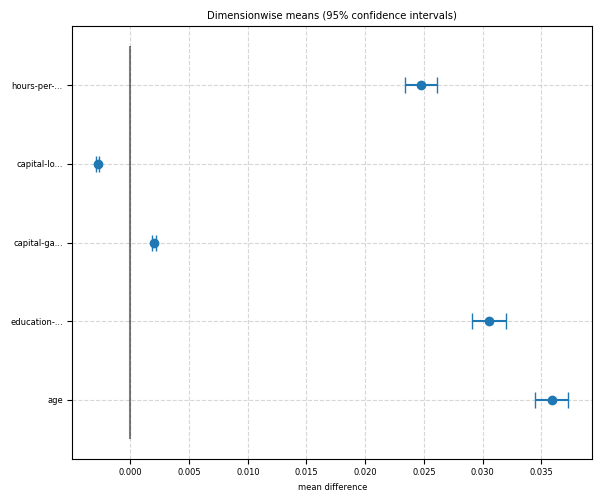

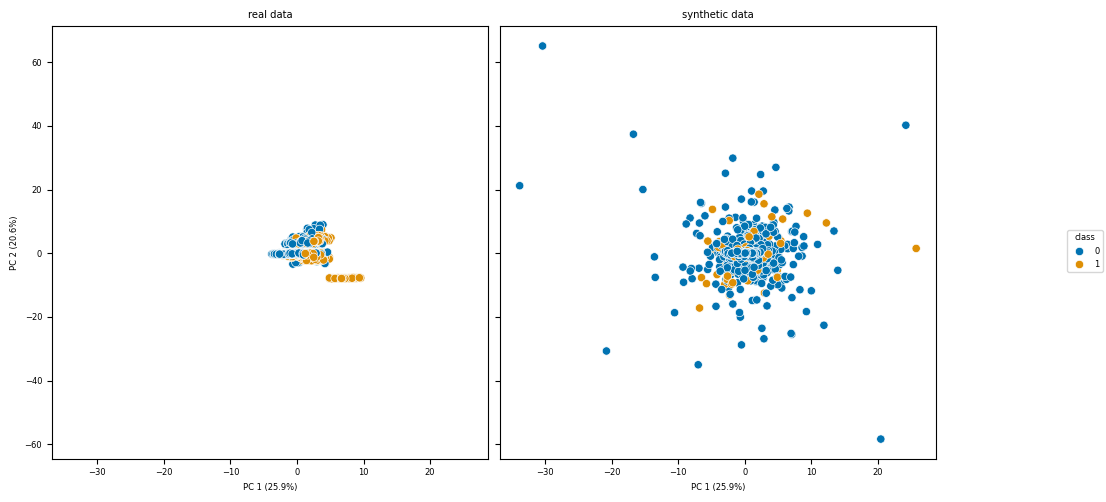

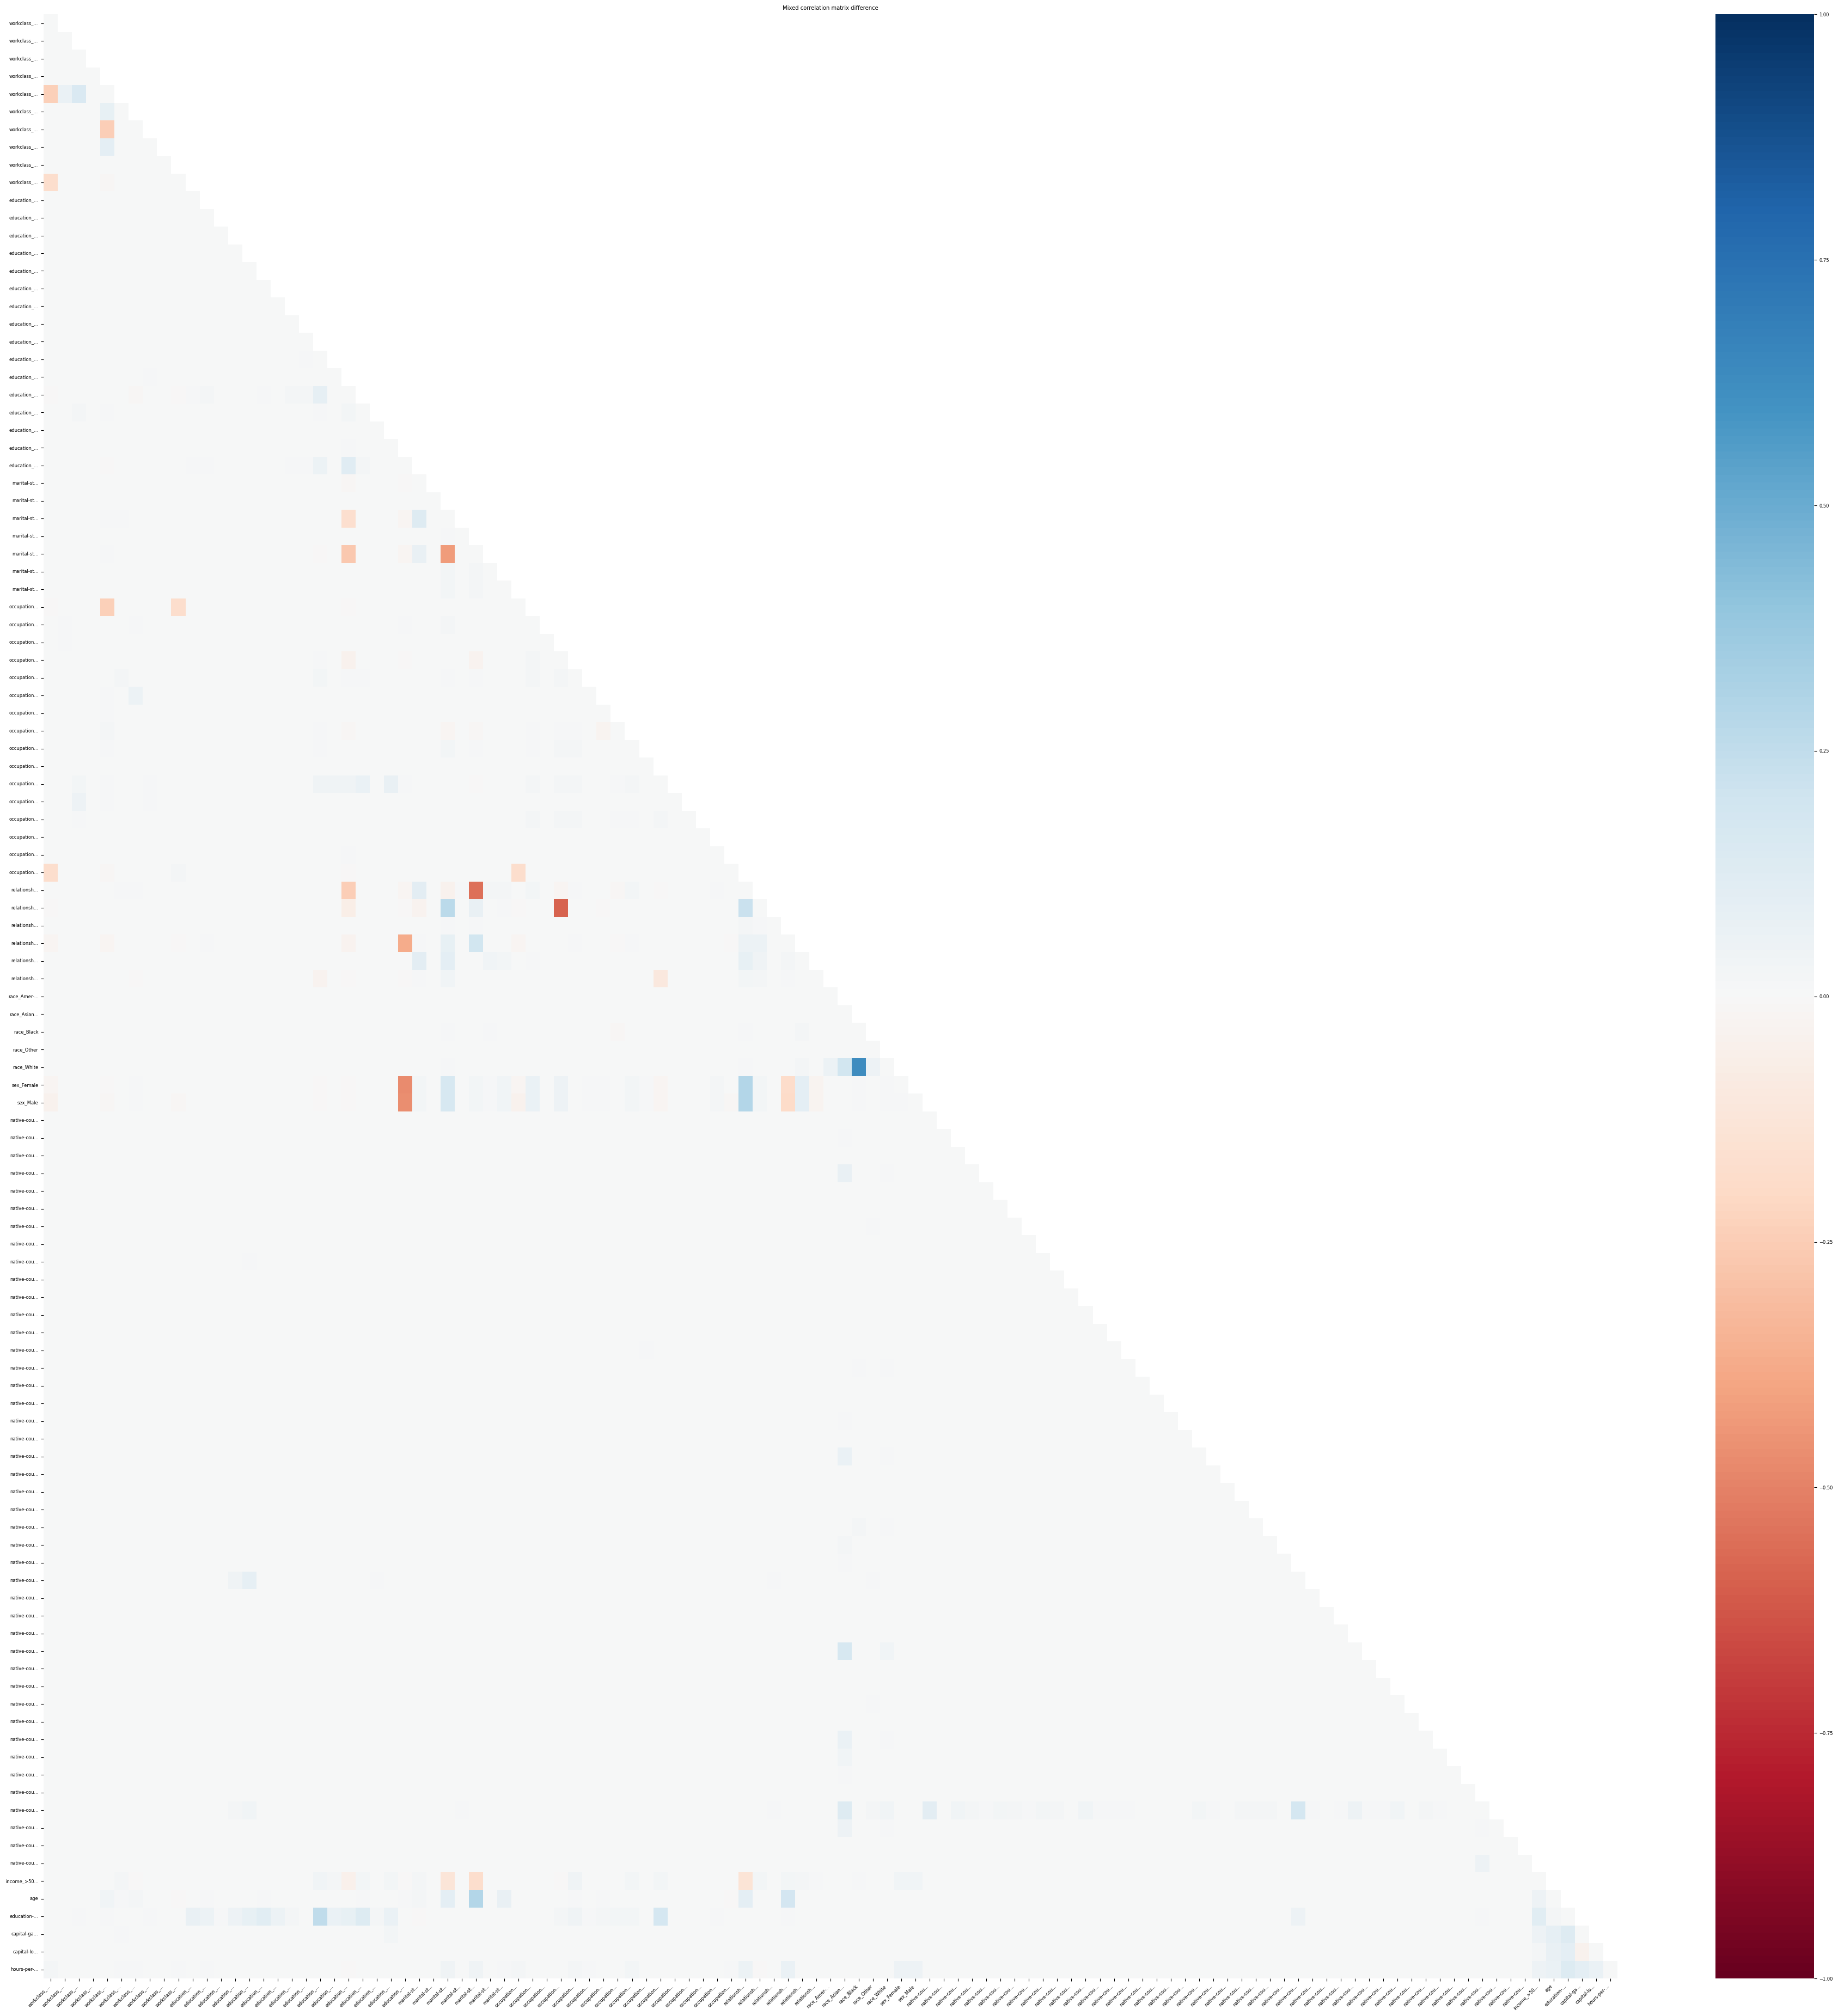

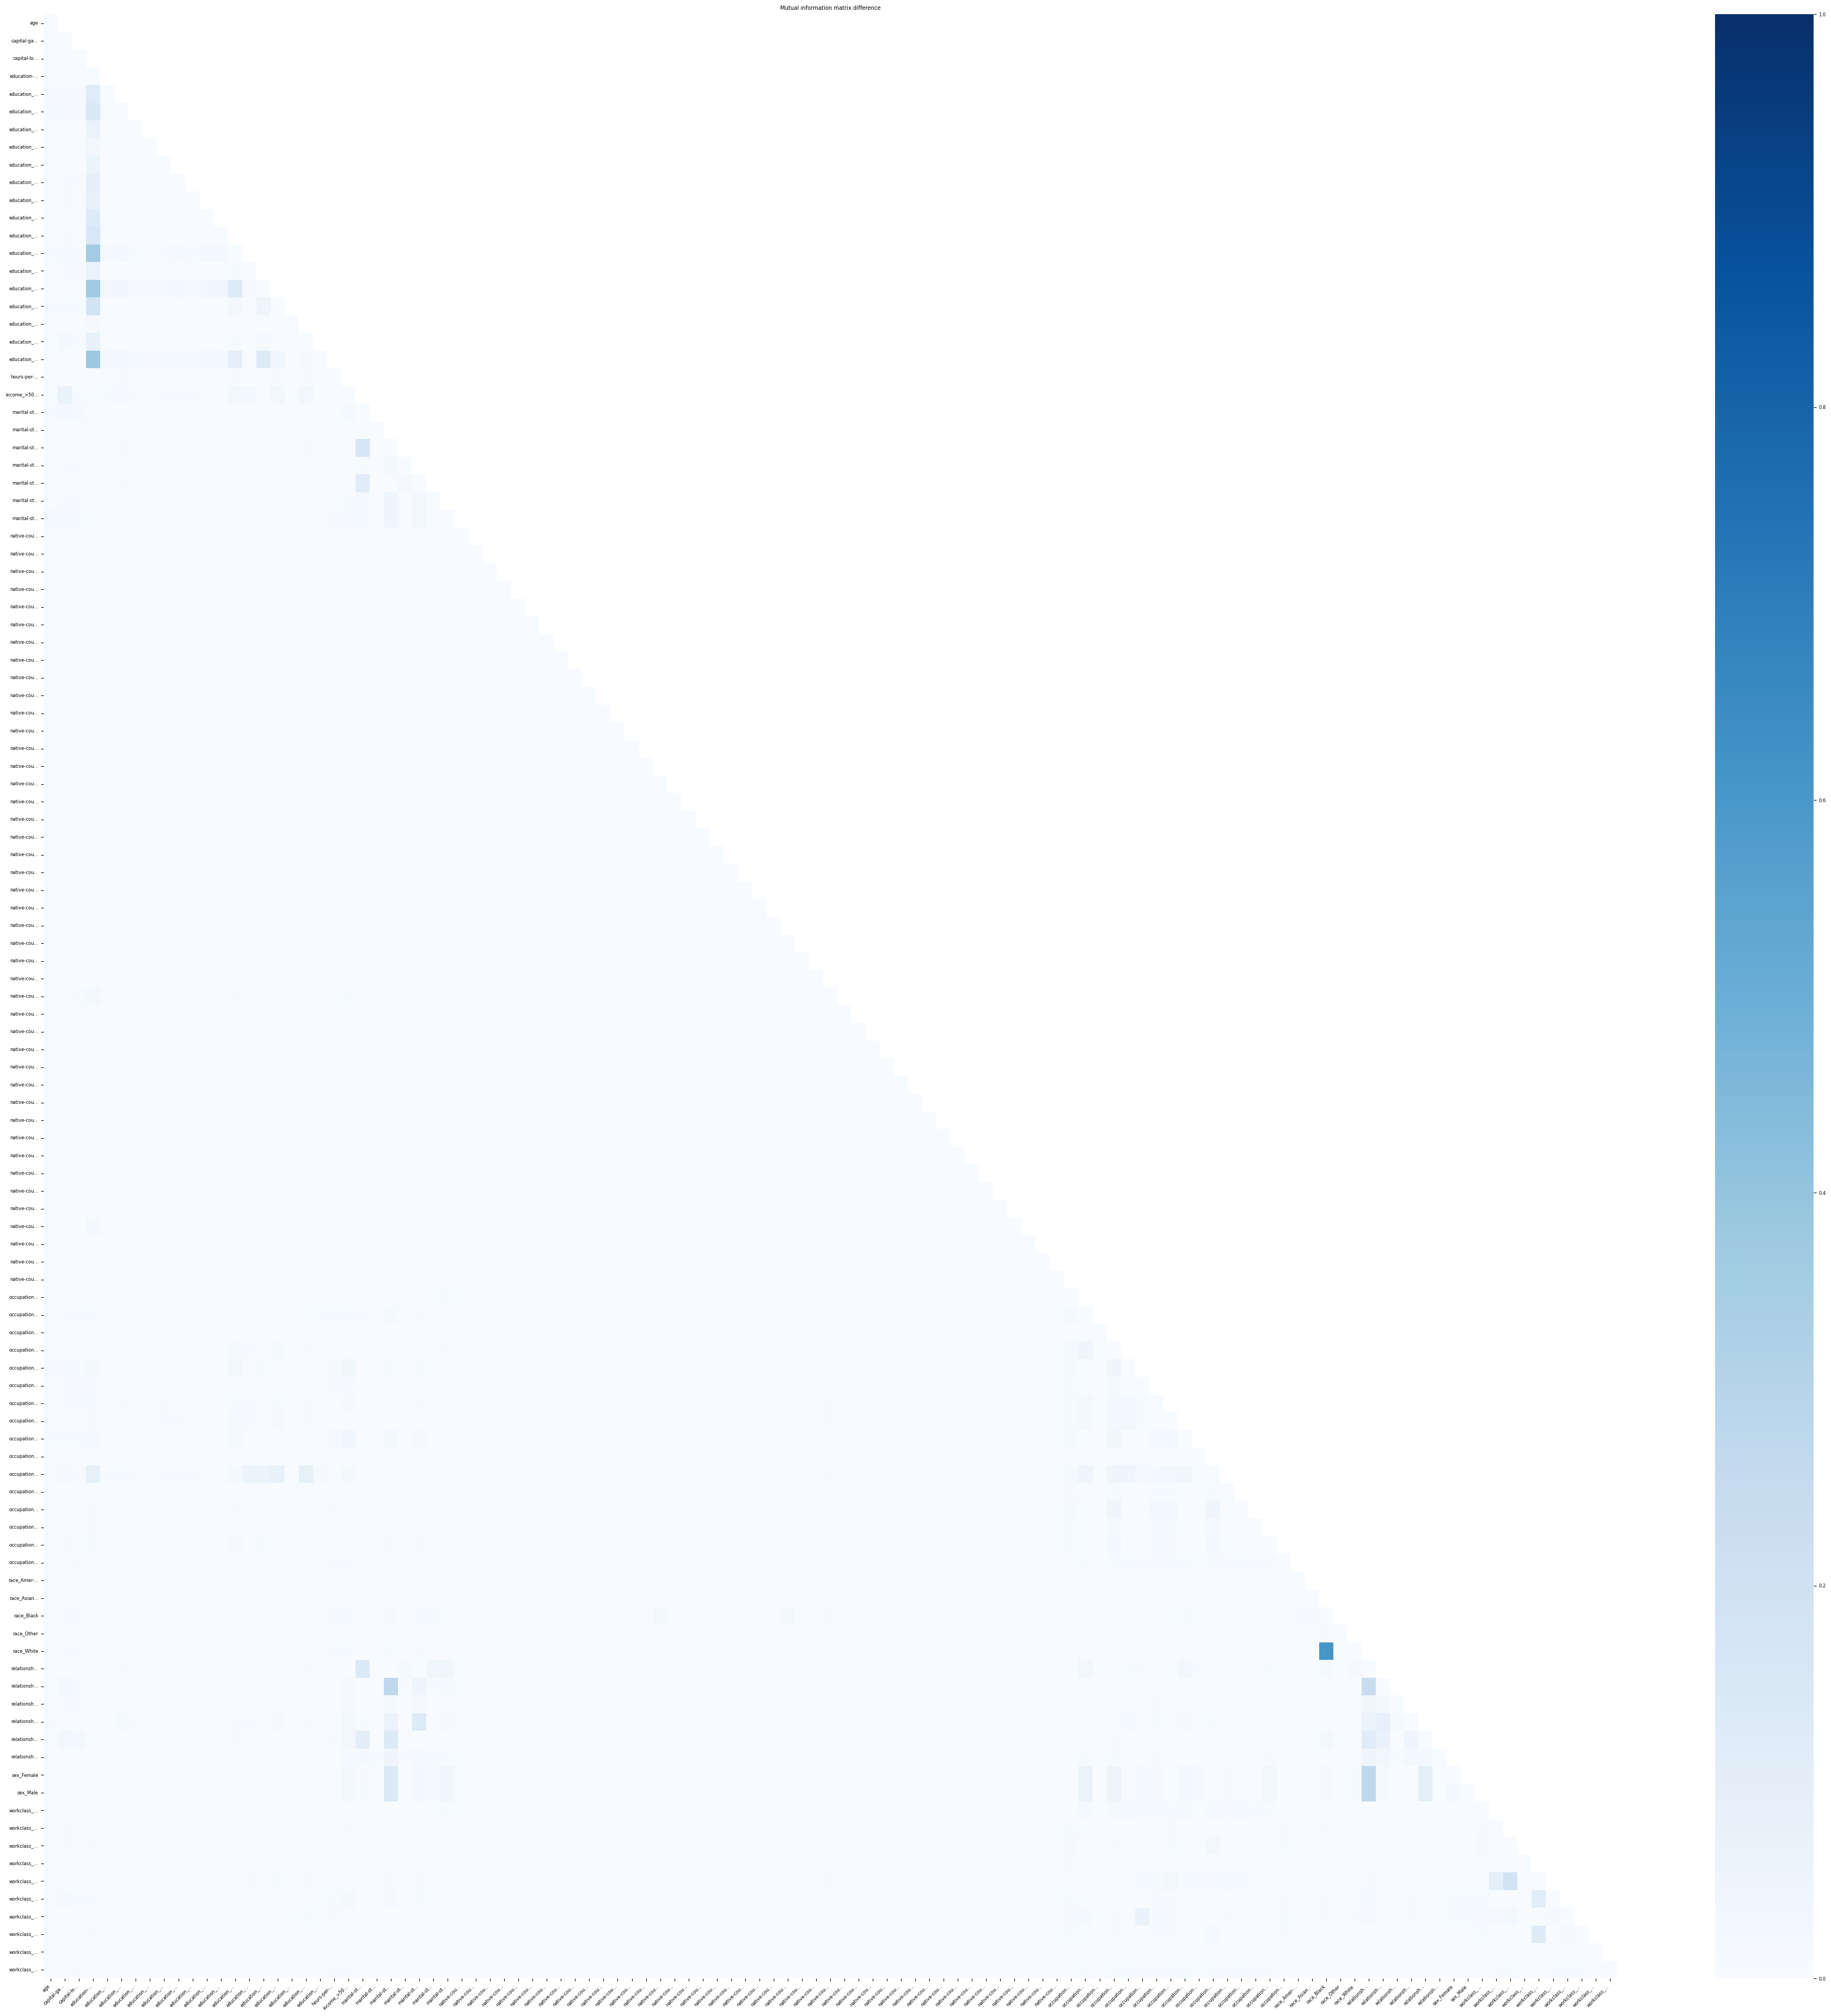

In [12]:
S = SynthEval(df_real)
resultsDict = S.evaluate(df_fake,'income_>50K',"full_eval")
